# `pyGIMLi(emg3d)`

Create an env with the correct packages using
```bash
conda env create
conda activate pg-emg3d
python -m ipykernel install --user --name pg-emg3d
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import toyexample

import emg3d
import pygimli as pg

%load_ext autoreload
%autoreload 2

## Load Simulation (incl. Survey, Models, Data)

Data loaded from «/home/dtr/Codes/dev-pygimli-emg3d/toy-tiny.h5»
[emg3d v1.8.4.dev6+gd2f88de (format 1.0) on 2024-08-28T16:17:44.833349].


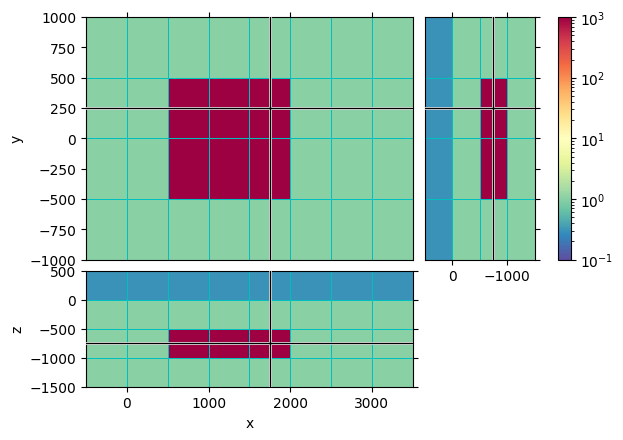


  TensorMesh: 128 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x      8       -500.00      3,500.00    500.00    500.00    1.00
   y      4     -1,000.00      1,000.00    500.00    500.00    1.00
   z      4     -1,500.00        500.00    500.00    500.00    1.00


Model: conductivity; isotropic; 8 x 4 x 4 (128)
:: Simulation ::

- Survey: 1 sources; 130 receivers; 1 frequencies
- Model: conductivity; isotropic; 8 x 4 x 4 (128)
- Gridding: Frequency- and source-dependent grids; 64 x 48 x 40 (122,880)


In [2]:
#name = 'toy-small.h5'
name = 'toy-tiny.h5'
try:
    toy = toyexample.get_data(name)
except:
    toyexample.create_data()
    toy = toyexample.get_data(name)

sim, model_true, model_start, grid = toy

sim.tol_gradient = 1e-2 # Reduce further

## Define regions, instantiate Kernel and Inversion

In [3]:
# Create region markers (as many different regions as you like)
markers = np.zeros(model_start.shape, dtype=int)
#markers[:, :, grid.cell_centers_z > -500] = 1     # top two layers and bottom two layers
markers[model_true.property_x < 0.1] = 1            # Only target is free
#markers = np.zeros(model_start.shape, dtype=int)
#markers[1:-1, :, :][:, 1:-1, :][:, :, 1:-2] = 1
#markers[1:-1, :, :][:, 1:-1, :][:, :, 1:-3] = 1
#markers[1:-1, :, :][:, 1:-1, :][:, :, -3:-1] = 2
#markers[1:-1, :, :][:, 1:-1, :][:, :, -2] = 2
#markers[1:-1, :, :][:, 1:-1, :][:, :, -3] = 3

# Instantiate the emg3d-kernel for pyGIMLi
fop = emg3d.inversion.pygimli.Kernel(simulation=sim, markers=markers, pgthreads=1)

# Instantiate the inversion and set some inversion parameters
INV = emg3d.inversion.pygimli.Inversion(fop=fop)
INV.inv.setCGLSTolerance(10)  # is _absolute_, not _relative_
INV.inv.setMaxCGLSIter(30)
#INV.dataTrans = pg.trans.TransSymLog(sim.survey.noise_floor)

# Set the regions.
# Any number of regions is possible; alse `fix=True`, `single=True`, and `background=True`.
# Two different ways of the same: INV.setRegularization; INV.fop.setRegionProperties
INV.fop.setRegionProperties(1, #single=True,
                            limits=(0.0001, 2), startModel=1)                  # Target
INV.fop.setRegionProperties(0, background=True)                                   # Background
#INV.fop.setRegionProperties(2, fix=True, startModel=1)                           # Background
#INV.fop.setRegionProperties(3, single=True, limits=(0.1, 10.0), startModel=1.0)  # Background

# Constrain types (cType)
# 0 only damping (minimum length; only useful with good starting model and isReference=True in INV)
# 1 1st deriv - smoothing
# 2 2nd deriv
# 10, 20 - mixed form

# Depth weighting
# https://www.pygimli.org/_examples_auto/4_gravimetry_magnetics/plot_08_inv-magnetics-3d.html#depth-weighting

## Run inversion

In [4]:
#INV.stopAtChi1 = False
INV.run(
    #maxIter=2, # just to test
    lam=10,  # btw 1-100
    #verbose=True,
    #debug=True,
    #startModel=model_true.property_x.ravel('F'),
    #isReference=True,
)

28/08/24 - 16:20:43 - pyGIMLi - INFO - :: pyGIMLi(emg3d) START ::
28/08/24 - 16:20:43 - pyGIMLi - INFO - Created startmodel from region infos: 6 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
28/08/24 - 16:20:46 - pyGIMLi - INFO - =======================================================================
                                        it        χ²   F(m)       λ         ϕᵈ         ϕᵐ   ϕ=ϕᵈ+λϕᵐ   Δϕ (%)
                                       -----------------------------------------------------------------------
28/08/24 - 16:20:46 - pyGIMLi - INFO -   0      17.5      1    10.0     4537.9        0.0     4537.9     0.00
28/08/24 - 16:21:02 - pyGIMLi - INFO -   1       0.4     10    10.0      107.8        1.7      124.6    97.25
28/08/24 - 16:21:02 - pyGIMLi - INFO - :: pyGIMLi(emg3d) END   :: runtime = 0:00:19


# Plots

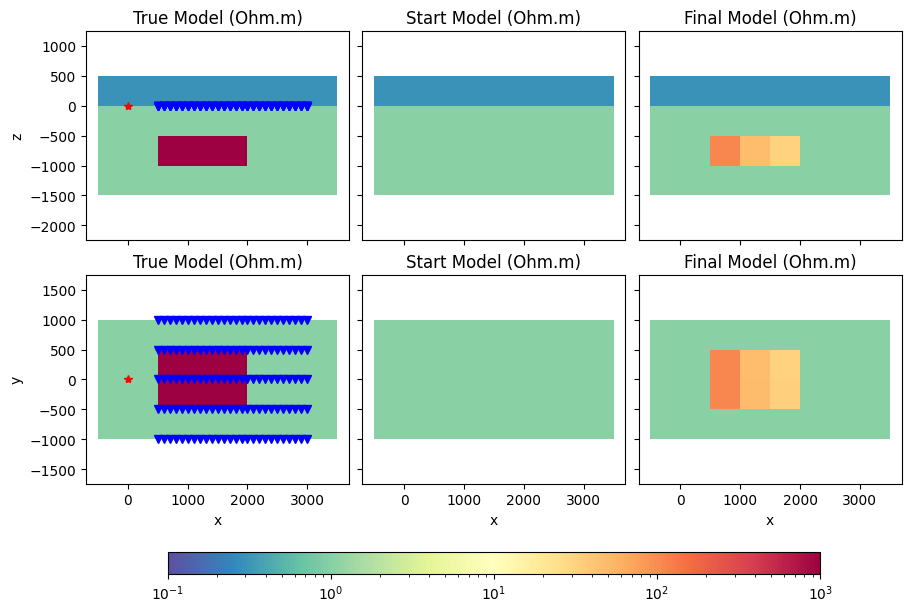

In [5]:
toyexample.plot_models(sim, model_start, model_true)

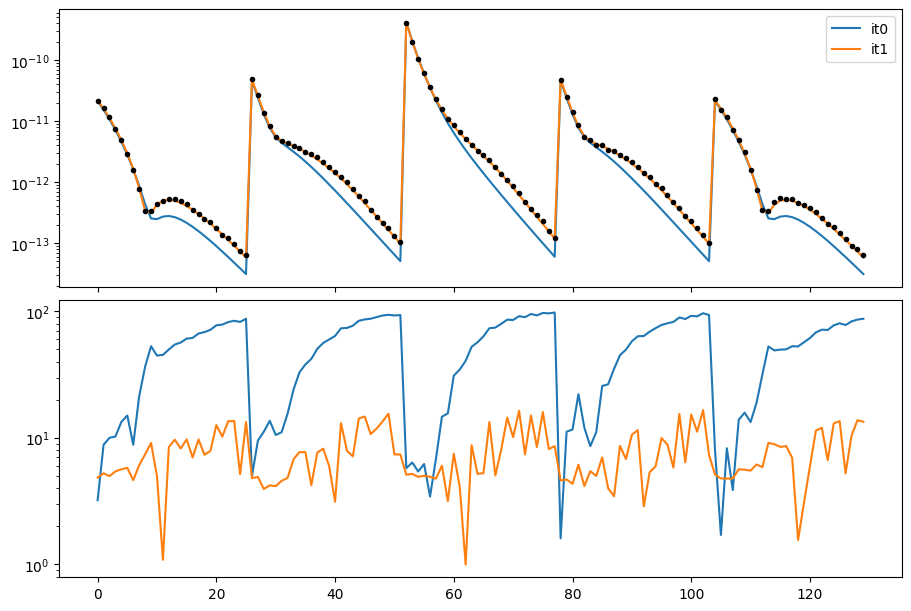

In [6]:
toyexample.plot_responses(sim)

In [7]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Wed Aug 28 16:21:03 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.59.1
             emg3d : 1.8.4.dev6+gd2f88de
           empymod : 2.3.1
            xarray : 2024.6.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.9.1
              tqdm : 4.66.4
           IPython : 8.26.0
           pygimli : 1.5.2
            pgcore : 1.5.0
--------------------------------------------------------------------------------